# Setting up the GPU Environment

#### Install Dependencies and Restart Runtime

In [1]:
!pip install -q transformers
!pip install -q simpletransformers
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.8/250.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 22.9 MB/s eta 0:00:00


In [2]:
!pip install h5py
!pip install typing-extensions
!pip install wheel

# Getting Data

#### Dataset Description

The IMDb dataset is a binary sentiment analysis dataset consisting of 50,000 reviews from the Internet Movie Database (IMDb) labeled as positive or negative (this is the polarity). The dataset contains of an even number of positive and negative reviews (balanced). Only highly polarizing reviews are considered. A negative review has a score ≤ 4 out of 10, and a positive review has a score ≥ 7 out of 10. No more than 30 reviews are included per movie. There are 25,000 highly polar movie reviews for training, and 25,000 for testing.

#### Pulling the data from `huggingface/datasets`

We use Hugging Face's awesome datasets library to get the pre-processed version of the original [IMDB dataset](https://ai.stanford.edu/~amaas/data/sentiment/).

The code below pulls the train and test datasets from [huggingface/datasets](https://github.com/huggingface/datasets) using `load_dataset('imdb')` and transform them into `pandas` dataframes for use with the `simpletransformers` library to train the model.

In [3]:
import pandas as pd
from datasets import load_dataset

dataset_train = load_dataset('imdb',split='train')
#aset_train.rename_column_('label', 'labels')
train_df=pd.DataFrame(dataset_train)

dataset_test = load_dataset('imdb',split='test')
#dataset_test.rename_column_('label', 'labels')
test_df=pd.DataFrame(dataset_test)

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Once done we can take a look at the `head()` of the training set to check if our data has been retrieved properly.

In [4]:
train_df.head()

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [5]:
train_df.rename(columns = {'label':'labels'}, inplace = True)

In [6]:
test_df.rename(columns = {'label':'labels'}, inplace = True)

In [7]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [8]:
val_df.shape

(5000, 2)

We also double check the dataset properties are exactly the same as those reported in the papers (25,000 train, 25,000 test size, balanced). **`0`** is the **`negative`** polarity class while **`1`** is the **`positive`** polarity class.

In [9]:
data = [
    [train_df.labels.value_counts()[0], val_df.labels.value_counts()[0], test_df.labels.value_counts()[0]],
    [train_df.labels.value_counts()[1], val_df.labels.value_counts()[1], test_df.labels.value_counts()[1]]
]

# Prints out the dataset sizes of train test and validate as per the table.
pd.DataFrame(data, columns=["Train", "Validation", "Test"])

,Train,Validation,Test
0,9985,2515,12500
1,10015,2485,12500


# Training and Testing the Model

In [10]:
train_args = {
    'reprocess_input_data': True,
    'overwrite_output_dir': True,
    'sliding_window': True,
    'max_seq_length': 64,
    'num_train_epochs': 4,
    'learning_rate': 0.00001,
    'weight_decay': 0.01,
    'train_batch_size': 128,
    'fp16': True,
    'output_dir': '/outputs/',
}

In [11]:
import time

In [12]:
%%time
from simpletransformers.classification import ClassificationModel
import pandas as pd
import logging
import sklearn

logging.basicConfig(level=logging.DEBUG)
transformers_logger = logging.getLogger('transformers')
transformers_logger.setLevel(logging.WARNING)

# We use the XLNet base cased pre-trained model.
model = ClassificationModel('xlnet', 'xlnet-base-cased', num_labels=2, args=train_args)
start_time = time.time()  # Record the start time
# Train the model, there is no development or validation set for this dataset
# https://simpletransformers.ai/docs/tips-and-tricks/#using-early-stopping
model.train_model(train_df, eval_df=val_df)

end_time = time.time()  # Record the end time
training_time = end_time - start_time  # Calculate the training time
print(f"Training time: {training_time:.2f} seconds")

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/1081 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/1081 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/1081 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/1081 [00:00<?, ?it/s]

Training time: 2858.77 seconds
CPU times: user 49min 22s, sys: 2min 58s, total: 52min 20s
Wall time: 48min 21s


In [13]:
# Use the model to predict on train  data
result_train, model_outputs_train, wrong_predictions_train = model.eval_model(train_df)

  0%|          | 0/20000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/17294 [00:00<?, ?it/s]

In [16]:
print(result_train)

{'mcc': 0.9264127047991206, 'tp': 9865, 'tn': 9390, 'fp': 595, 'fn': 150, 'eval_loss': 0.2507857379574741}


In [17]:
def calculate_accuracy(tp, tn, fp, fn):
    total_samples = tp + tn + fp + fn
    accuracy = (tp + tn) / total_samples if total_samples != 0 else 0
    return accuracy

In [18]:
def calculate_precision_recall(tp, tn, fp, fn):
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    return precision, recall

In [19]:
def calculate_f1_score(precision, recall):
    f1_score = (2 * precision * recall) / (precision + recall)
    return f1_score

In [20]:
from transformers import PrinterCallback

train_LOSS=result_train['eval_loss']
train_TP=result_train['tp']
train_TN=result_train['tn']
train_FP=result_train['fp']
train_FN=result_train['fn']
train_accuracy = calculate_accuracy(train_TP,train_TN,train_FP,train_FN)
print("Accuracy:", train_accuracy)
print("True Postive:",train_TP )
print("True Negative:",train_TN )
print("False Postive:",train_FP )
print("False Negative:",train_FN )

Accuracy: 0.96275
True Postive: 9865
True Negative: 9390
False Postive: 595
False Negative: 150


In [21]:
train_precision,train_recall=calculate_precision_recall(train_TP,train_TN,train_FP,train_FN)
train_f1 = calculate_f1_score(train_precision, train_recall)
print("Accuracy:", train_accuracy)
print("Precision:", train_precision)
print("Recall:", train_recall)
print("F1 Score:",train_f1)

Accuracy: 0.96275
Precision: 0.9431166347992351
Recall: 0.9850224663005491
F1 Score: 0.9636141636141635


In [22]:
# Use the model to predict on validation data
result_val, model_outputs_val, wrong_predictions_val = model.eval_model(val_df)

  0%|          | 0/5000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/4350 [00:00<?, ?it/s]

In [23]:
print(result_val)

{'mcc': 0.8613153185625488, 'tp': 2378, 'tn': 2272, 'fp': 243, 'fn': 107, 'eval_loss': 0.3852281649564875}


In [24]:
def calculate_accuracy(tp, tn, fp, fn):
    total_samples = tp + tn + fp + fn
    accuracy = (tp + tn) / total_samples if total_samples != 0 else 0
    return accuracy

In [25]:
def calculate_f1_score(precision, recall):
    f1_score = (2 * precision * recall) / (precision + recall)
    return f1_score

In [26]:
VAL_LOSS=result_val['eval_loss']
VAL_TP=result_val['tp']
VAL_TN=result_val['tn']
VAL_FP=result_val['fp']
VAL_FN=result_val['fn']
VAL_accuracy = calculate_accuracy(VAL_TP,VAL_TN,VAL_FP,VAL_FN)
print("Accuracy:", VAL_accuracy)
print("True Postive:",VAL_TP )
print("True Negative:",VAL_TN )
print("False Postive:",VAL_FP )
print("False Negative:",VAL_FN )

Accuracy: 0.93
True Postive: 2378
True Negative: 2272
False Postive: 243
False Negative: 107


In [27]:
def calculate_precision_recall(tp, tn, fp, fn):
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    return precision, recall

In [28]:
def calculate_f1_score(precision, recall):
    f1_score = (2 * precision * recall) / (precision + recall)
    return f1_score

In [29]:
# Calculate F1 score

VAL_precision,VAL_recall=calculate_precision_recall(VAL_TP,VAL_TN,VAL_FP,VAL_FN)
VAL_f1 = calculate_f1_score(VAL_precision, VAL_recall)
print("Accuracy:", VAL_accuracy)
print("Precision:", VAL_precision)
print("Recall:", VAL_recall)
print("F1 Score:",VAL_f1)

Accuracy: 0.93
Precision: 0.9072872949256009
Recall: 0.9569416498993963
F1 Score: 0.9314531923227575


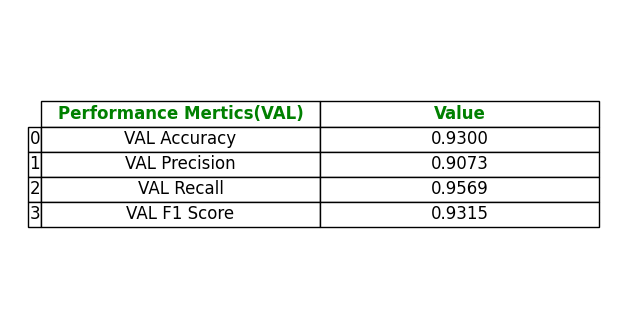

In [30]:
import matplotlib.pyplot as plt
from pandas.plotting import table

# Sample values
evaluation_metrics = ['VAL Accuracy', 'VAL Precision', 'VAL Recall', 'VAL F1 Score']
values = [format(VAL_accuracy, ".4f"),format(VAL_precision, ".4f") , format(VAL_recall, ".4f"), format(VAL_f1, ".4f"),]

# Create a DataFrame to store the evaluation metrics
import pandas as pd
data = {'Performance Mertics(VAL)': evaluation_metrics, 'Value': values}
df = pd.DataFrame(data)

# Create a plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create a table without borders and headers
tab = table(ax, df, loc='center', cellLoc='center', colWidths=[0.3, 0.3])
tab.auto_set_font_size(False)
tab.set_fontsize(12)
tab.scale(1.5, 1.5)

# Change color of headers and make them bold
for key, cell in tab.get_celld().items():
    if key[0] == 0:  # Header row
        cell.set_text_props(weight='bold', color='green')

plt.savefig('evaluation_metrics_table.png', dpi=300, bbox_inches='tight')
plt.show()

In [31]:
# Evaluate the model in terms of accuracy score
result_test, model_outputs_test, wrong_predictions_test = model.eval_model(test_df, acc=sklearn.metrics.accuracy_score)

  0%|          | 0/25000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21178 [00:00<?, ?it/s]

In [ ]:
print(result_test)

{'mcc': 0.8383263240063912, 'tp': 11955, 'tn': 10993, 'fp': 1507, 'fn': 545, 'acc': 0.91792, 'eval_loss': 0.3854756217433368}


In [35]:
TEST_LOSS=result_test['eval_loss']
TEST_accuracy = result_test['acc']
TEST_TP=result_test['tp']
TEST_TN=result_test['tn']
TEST_FP=result_test['fp']
TEST_FN=result_test['fn']
print("Accuracy:", TEST_accuracy)
print("True Postive:",TEST_TP )
print("True Negative:",TEST_TN )
print("False Postive:",TEST_FP )
print("False Negative:",TEST_FN )

Accuracy: 0.92736
True Postive: 12027
True Negative: 11157
False Postive: 1343
False Negative: 473


In [32]:
def calculate_precision_recall(tp, tn, fp, fn):
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    return precision, recall

In [33]:
def calculate_f1_score(precision, recall):
    f1_score = (2 * precision * recall) / (precision + recall)
    return f1_score

In [36]:


# Calculate F1 score

TEST_precision,TEST_recall=calculate_precision_recall(TEST_TP,TEST_TN,TEST_FP,TEST_FN)
TEST_f1 = calculate_f1_score(TEST_precision, TEST_recall)
print("Accuracy:", TEST_accuracy)
print("Precision:", TEST_precision)
print("Recall:", TEST_recall)
print("F1 Score:",TEST_f1)

Accuracy: 0.92736
Precision: 0.899551234106208
Recall: 0.96216
F1 Score: 0.9298028604561268


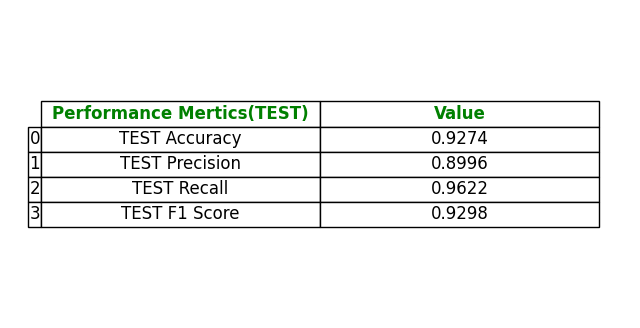

In [37]:
import matplotlib.pyplot as plt
from pandas.plotting import table

# Sample values
evaluation_metrics = ['TEST Accuracy', 'TEST Precision', 'TEST Recall', 'TEST F1 Score']
values = [format(TEST_accuracy, ".4f"),format(TEST_precision, ".4f") , format(TEST_recall, ".4f"), format(TEST_f1, ".4f"),]

# Create a DataFrame to store the evaluation metrics
import pandas as pd
data = {'Performance Mertics(TEST)': evaluation_metrics, 'Value': values}
df = pd.DataFrame(data)

# Create a plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create a table without borders and headers
tab = table(ax, df, loc='center', cellLoc='center', colWidths=[0.3, 0.3])
tab.auto_set_font_size(False)
tab.set_fontsize(12)
tab.scale(1.5, 1.5)

# Change color of headers and make them bold
for key, cell in tab.get_celld().items():
    if key[0] == 0:  # Header row
        cell.set_text_props(weight='bold', color='green')

plt.savefig('evaluation_metrics_table.png', dpi=300, bbox_inches='tight')
plt.show()

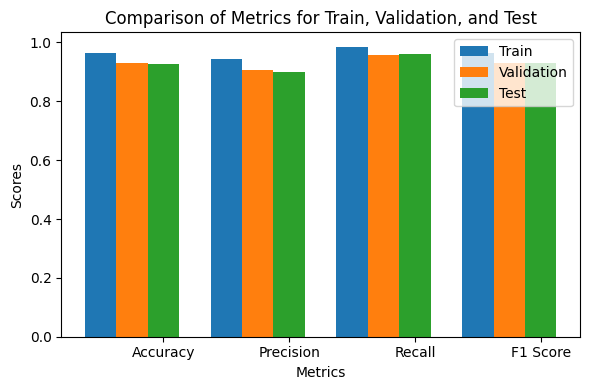

In [38]:
# Metrics for Train and Validation
metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score"]
train_metrics = [train_accuracy, train_precision, train_recall, train_f1]
val_metrics = [VAL_accuracy, VAL_precision, VAL_recall, VAL_f1]
test_metrics = [TEST_accuracy, TEST_precision, TEST_recall, TEST_f1]
# Number of metrics
num_metrics = len(metrics_names)

# Plotting
fig, ax = plt.subplots(figsize=(6, 4))
bar_width = 0.25

# Set positions for the bars
positions_train = range(num_metrics)
positions_val = [pos + bar_width for pos in positions_train]
positions_test = [pos + bar_width for pos in positions_val]

# Plot bars for Train, Validation, and Test
ax.bar(positions_train, train_metrics, bar_width, label='Train')
ax.bar(positions_val, val_metrics, bar_width, label='Validation')
ax.bar(positions_test, test_metrics, bar_width, label='Test')

# Set labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Metrics for Train, Validation, and Test')
ax.set_xticks([pos + bar_width for pos in positions_val])
ax.set_xticklabels(metrics_names)
ax.legend()

plt.tight_layout()
plt.show()

In [39]:
text_list = test_df['text'].tolist()

In [40]:
# Get predicted probabilities for positive class (label 1)
predictions, prob_scores = model.predict(text_list)
y_true_test = test_df['labels'].tolist()

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/21178 [00:00<?, ?it/s]

In [41]:
# Evaluate the model's accuracy, AUC, and generate a confusion matrix
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc

In [42]:
y_pred_test=predictions

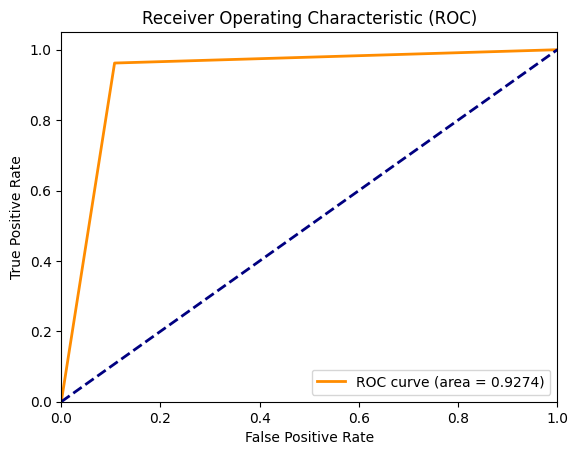

In [43]:
fpr_test, tpr_test, thresholds = roc_curve(y_true_test, y_pred_test)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

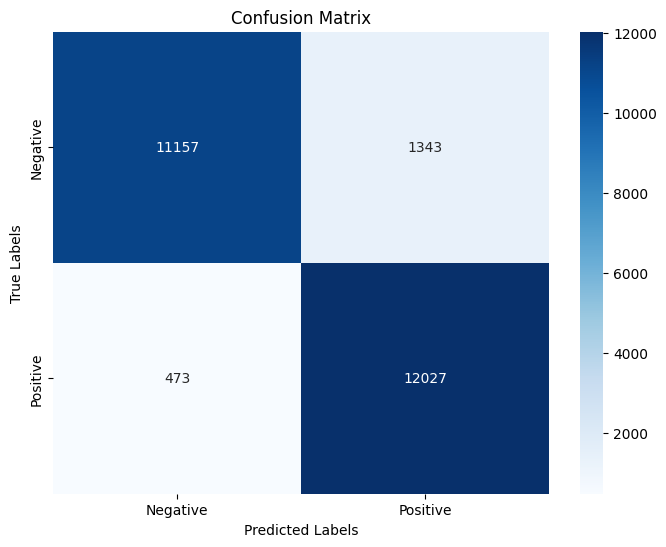

In [44]:
from sklearn.metrics import confusion_matrix,roc_curve
import numpy as np
import seaborn as sns

conf_matrix = np.array([[TEST_TN, TEST_FP],
                        [TEST_FN, TEST_TP]])

# Plot Confusion Matrix as a Heatmap
class_names = ['Negative', 'Positive']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".0f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

We see that the output accuracy from the model after training for 1 epoch is **92.2%** ('acc': 0.92156).

## Using the Model (Running Inference)

Running the model to do some predictions/inference is as simple as calling `model.predict(input_list)`.

In [ ]:
samples =  [
    'Captivating, heartwarming film. Superb acting, engaging plot. A must-watch for a feel-good experience.',  # this is the same sentence tried earlier
    'The movie was great!',
    'Dull plot, unconvincing acting. Lacks depth. Disappointing overall. Not recommended for a satisfying movie experience.',
    'Amid convoluted storytelling, insipid characters, and erratic pacing, the movie falters, failing to captivate or engage',
    'The movie was terrible...'
]
predictions, _ = model.predict(samples)
label_dict = {0: 'negative', 1: 'positive'}
for idx, sample in enumerate(samples):
  print('{} - {}: {}'.format(idx, label_dict[predictions[idx]], sample))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0 - positive: Captivating, heartwarming film. Superb acting, engaging plot. A must-watch for a feel-good experience.
1 - positive: The movie was great!
2 - negative: Dull plot, unconvincing acting. Lacks depth. Disappointing overall. Not recommended for a satisfying movie experience.
3 - negative: Amid convoluted storytelling, insipid characters, and erratic pacing, the movie falters, failing to captivate or engage
4 - negative: The movie was terrible...


We can connect to Google Drive with the following code to save any files you want to persist. You can also click the `Files` icon on the left panel and click `Mount Drive` to mount your Google Drive.

The root of your Google Drive will be mounted to `/content/drive/My Drive/`. If you have problems mounting the drive, you can check out this [tutorial](https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166).

You can move the model checkpount files which are saved in the `/outputs/` directory to your Google Drive.